# Imports

In [1]:
import numpy as np
import itertools as itt
import tensorflow as tf
from tensorflow.keras import backend as K

import numpy.linalg as la

import scipy.stats as st
import numpy.random as rnd

import matplotlib.pyplot as pl
%matplotlib inline

from importlib import reload

import ipywidgets as ipw

In [2]:
from polys2 import Poly, PolyMesh, TaylorGrid

In [3]:
## changing the width of cells
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

## Auxilliary methods for working with batches

In [4]:
import polys2.batch_utils as pib

In [5]:
def plot_batched_objects(objs, names = None, subplots_kwargs = {}):
    if names is None:
        names = [ "obj_" + str(i) for i, o in enumerate(objs) ]
       
    def fun(ii):
        print("batch_index =", ii)
        fig, axs = pl.subplots(nrows=1, ncols=len(objs), figsize= (5 * len(objs), 5), **subplots_kwargs)
        axs = np.array(axs, dtype = np.object)
        for name, obj, ax in zip(names, objs, axs.flat):
            pl.sca(ax)
            ax.set_title(name)
            obj.batch[ii].plot()
            
    pib.interact_along_batch(
        batch_shape = pib.get_common_broadcasted_shape([obj.batch_shape for obj in objs]), 
        display_fun = fun
    )

# Poly class - simple examples
#### 1D example

In [6]:
g = Poly(tf.constant([1, 2], dtype=K.floatx()))
g

Poly( tf.Tensor([1. 2.], shape=(2,), dtype=float32) )

In [7]:
g * g

Poly( tf.Tensor([1. 4. 4.], shape=(3,), dtype=float32) )

In [8]:
## evaluate `g`
t = tf.Variable([1], dtype = K.floatx())
g(t)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

In [9]:
f = Poly(tf.constant([1, 0, 1], dtype = K.floatx()))
f

Poly( tf.Tensor([1. 0. 1.], shape=(3,), dtype=float32) )

In [10]:
[f*f, f*3, f + g, f + 3, f.truncate_degs(2), f.truncated_exp()]

[Poly( tf.Tensor([1. 0. 2. 0. 1.], shape=(5,), dtype=float32) ),
 Poly( tf.Tensor([3. 0. 3.], shape=(3,), dtype=float32) ),
 Poly( tf.Tensor([2. 2. 1.], shape=(3,), dtype=float32) ),
 Poly( tf.Tensor([4. 0. 1.], shape=(3,), dtype=float32) ),
 Poly( tf.Tensor([1. 0.], shape=(2,), dtype=float32) ),
 Poly( tf.Tensor([2.7182817 0.        2.7182817], shape=(3,), dtype=float32) )]

#### 2D example

In [11]:
# 2D example
f = Poly(tf.constant(rnd.randint(-3, 3, size = (10, 1, 6)), K.floatx()), batch_ndim=1)
g = Poly(tf.constant(rnd.randint(-3, 3, size = (10, 2, 1)), K.floatx()), batch_ndim=1)

In [12]:
pib.print_batched_objects(
    objs = [f, g, f * g, f + g, (f*g).truncate_degs(2), f.truncated_exp()], 
    names = ["f", "g",  "f * g", "f + g", "trunc(f*g)", "exp(f)"]
)

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

In [13]:
plot_batched_objects([f, g, f * g, f + g], names = ["f", "g",  "f * g", "f + g"], 
                     subplots_kwargs={"sharex": True, "sharey":True})

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

### Evaluation of Poly

In [14]:
x = tf.Variable([1, 2], name="x", dtype=K.floatx())

In [15]:
## `f` is a batched polynomial, thus to evaluate every one at `x` 
## we need to add one batch-dimension also to `x`
f(x[None, :])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-176.,  -15., -115.,  -93.,  -64.,  -74.,  -70., -126.,   44.,
        -48.], dtype=float32)>

# Other classes: `TaylorGrid`, `PolyMesh`

### Gaussian pdf 2D

Generate batches of precision matrices `prec` and means `mu`. You can choose `n` = 1 or 2.

In [16]:
n = 2
batch_ndim = 1
n_samples = 5000

def random_prec():
    scaling = np.diag(1 / rnd.uniform(0.1, 5 , size = n)) 
    phi = rnd.uniform(0, 2 * np.pi)
    rotation = np.array([
        [np.cos(phi), - np.sin(phi)], 
        [np.sin(phi), np.cos(phi)]
    ])
    return rotation @ scaling @ rotation.T
        
prec = tf.constant([random_prec() for i in range(n_samples)], K.floatx())

mu = tf.constant(rnd.randint(-1, 2, size=(n_samples, n)), K.floatx())
params = [tf.linspace(-4., 4., 10)]*n

Construct TaylorGrid taylors of Gauss PDF and the coresponding spline PolyMesh approximation

In [17]:
tg = TaylorGrid.from_Gauss_pdf(params, mu, prec, batch_ndim, var_ndim= n)
spline = tg.get_spline()

In [18]:
spline.integrate()

<tf.Tensor: shape=(5000,), dtype=float32, numpy=
array([0.983954  , 1.0010632 , 0.9364409 , ..., 0.90801764, 0.9637393 ,
       0.9968472 ], dtype=float32)>

In [19]:
print(spline.integrate())
print(tg.integrate_spline())

tf.Tensor([0.983954   1.0010632  0.9364409  ... 0.90801764 0.9637393  0.9968472 ], shape=(5000,), dtype=float32)
tf.Tensor([0.98395395 1.0010633  0.93644094 ... 0.90801764 0.9637394  0.9968473 ], shape=(5000,), dtype=float32)


In [20]:
%timeit spline.integrate()

9.83 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit 
spline = tg.get_spline()
spline.integrate()

106 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit tg.integrate_spline()

57.4 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


See the graphs of genuine PDF, our approximation and the approximation using Interpolators 

In [23]:
from polys2.interpolators import Interpolator

In [24]:
# if 2D use this visualization
def fun(ii):
    assert spline.var_ndim == 2, "This visualization works only in 2D case."
    f = spline.batch[ii]
    
    print("mu =" , mu[ii])
    print("K =" , prec[ii])
    f0 = st.multivariate_normal(mean = mu[ii], cov = la.inv(prec[ii])).pdf

    g = Interpolator.from_fun(params, f0)

    xxx, yyy = [np.linspace(par[0], par[-1], 30) for par in params]

    fig, axs = pl.subplots(1, 3, figsize = [15, 4])
    for ax in axs:
        ax.set_aspect("equal")

    levels = None
    for fun, title, ax  in zip([g, f, f0], ["Catmull-Rom", "PolyMesh cubic spline", "genuine Gauss"], axs):
        pl.sca(ax)
        fff = np.array([[ fun([x,y]) for y in yyy ] for x in xxx]).T
        print(title, "minimum is", fff.min(), type(fun) )
        cp = pl.contour( xxx, yyy, fff, 
            cmap=pl.cm.rainbow,
            levels = levels
        )
        pl.clabel(cp)

        pl.scatter(*zip(*itt.product(*[p.numpy() for p in params])), marker = "+")

        ax.set_title(title)

        levels = cp.levels
        
pib.interact_along_batch(spline.batch_shape, fun)# continuous_update=False)

interactive(children=(IntSlider(value=0, description='i0', max=4999), Output()), _dom_classes=('widget-interac…

### Gaussian pdf 1D

Generate batches of precision matrices `prec` and means `mu`. You can choose `n` = 1 or 2.

In [25]:
n = 1
batch_ndim = 1
n_samples = 5000

def random_prec():
    std = np.diag(rnd.uniform(0.3, 2 , size = n)) 
    return std ** (-2)
        
prec = tf.constant([random_prec() for i in range(n_samples)], K.floatx())

mu = tf.constant(rnd.randint(-1, 2, size=(n_samples, n)), K.floatx())
params = [tf.linspace(-4., 4., 10)]*n

Construct TaylorGrid taylors of Gauss PDF and the coresponding spline PolyMesh approximation

In [26]:
tg = TaylorGrid.from_Gauss_pdf(params, mu, prec, batch_ndim, var_ndim= n)
spline = tg.get_spline()

In [27]:
spline.integrate()

<tf.Tensor: shape=(5000,), dtype=float32, numpy=
array([0.9975726 , 0.9999518 , 0.987789  , ..., 0.9999811 , 0.98090875,
       0.9243336 ], dtype=float32)>

In [28]:
print(spline.integrate())
print(tg.integrate_spline())

tf.Tensor([0.9975726  0.9999518  0.987789   ... 0.9999811  0.98090875 0.9243336 ], shape=(5000,), dtype=float32)
tf.Tensor([0.99757266 0.9999518  0.9877889  ... 0.99998105 0.98090863 0.9243334 ], shape=(5000,), dtype=float32)


In [29]:
%timeit spline.integrate()

1.05 ms ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%%timeit 
spline = tg.get_spline()
spline.integrate()

22.3 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit tg.integrate_spline()

24.5 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
# if 1D use this visualization
def fun(ii):
    assert spline.var_ndim == 1, "This visualization works only in 1D case."
    
    f = spline.batch[ii]
    
    print(f"mean = {np.squeeze(mu[ii])}, std = {np.squeeze(prec[ii])**(-1/2)}")
    f0 = st.multivariate_normal(mean = mu[ii], cov = la.inv(prec[ii])).pdf
    g = Interpolator.from_fun(params, f0)
    
    par = params[0]
    xxx = np.linspace(par[0], par[-1], 100)
    for fun, title in zip([g, f, f0], ["Catmull-Rom", "PolyMesh cubic spline", "genuine Gauss"]):
        yyy = [fun([x]) for x in xxx]
        pl.plot(xxx, yyy, label = title)
    
    pl.legend(fontsize = 'xx-small')
    
pib.interact_along_batch(spline.batch_shape, fun )

interactive(children=(IntSlider(value=0, description='i0', max=4999), Output()), _dom_classes=('widget-interac…

### Splines from given Taylors at grid points

A polynomial of high order that we approximate by a spline

In [33]:
f = Poly(tf.constant([1, -1, 4, 0,0, -3], dtype=K.floatx()))

In [34]:
params = [tf.constant([0, 0.2, .5, 1], dtype=K.floatx())]
tg_f = f.get_taylor_grid(params, truncs = 2)

In [35]:
spline_f = tg_f.get_spline()

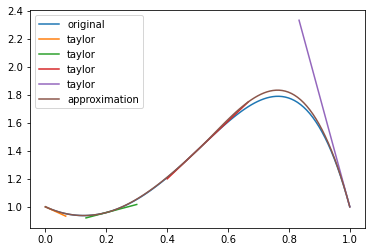

In [36]:
f.plot(label="original")
tg_f.plot(label="taylor")
spline_f.plot(label="approximation")
pl.legend()

In [37]:
plot_batched_objects(
    objs = [f, tg_f, spline_f], 
    names = ["original poly", "truncated Taylors at grid", "spline reconstruction"],
    subplots_kwargs={"sharex": True, "sharey":True}
)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

### Catmull-Rom splines

#### Example CR-01

In [38]:
xx = np.array([1, 2, 3, 4, 5], dtype=K.floatx())

yy = tf.Variable(rnd.randint(10, size = [10, len(xx)]), dtype=K.floatx())

taylors = TaylorGrid.from_Catmull_Rom(yy, params = [xx], batch_ndim=1)
spline = taylors.get_spline()

In [39]:
def fun(iii):
    taylors.batch[iii].plot(c = "g")
    pl.scatter(xx, yy[iii])
    spline.batch[iii].plot(c = "b")
    

pib.interact_along_batch(batch_shape=spline.batch_shape, display_fun=fun)

interactive(children=(IntSlider(value=0, description='i0', max=9), Output()), _dom_classes=('widget-interact',…

#### Example CR-02

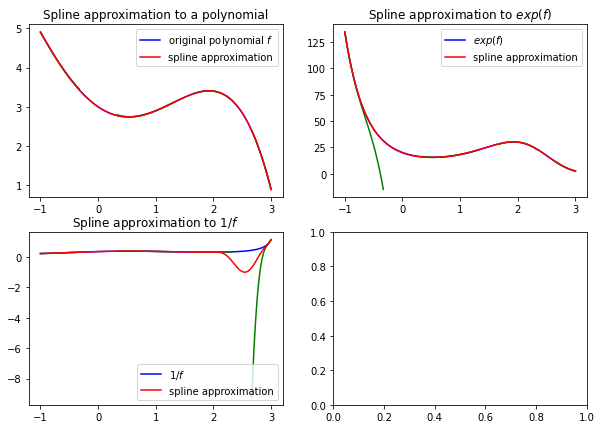

In [40]:
fig, axs = pl.subplots(2, 2, figsize = [10, 7])
axs = axs.flat

ax = axs[0]
pl.sca(ax)
ax.set_title("Spline approximation to a polynomial")

f = Poly(tf.constant([3, -1, 1, 0, -0.1]))

pg = f.get_taylor_grid([[-1, 1, 2, 3]], truncs = 4)
a, b = pg.params[0][0], pg.params[0][-1]
f.plot([a], [b], c = "b", label= "original polynomial $f$")

pg.plot(c = "g")

pm = pg.get_spline()
pm.plot(c = "r", label = "spline approximation")

ax.legend()

## exponential
ax = axs[1]
pl.sca(ax)
ax.set_title("Spline approximation to $exp(f)$")

xxx = np.linspace(a, b, 100)
yyy = np.exp(f.batch[None](xxx[:, None]))
pl.plot(xxx, yyy, c = "b", label= "$exp(f)$")

pg.truncated_exp().plot(c = "g")

pg.truncated_exp().get_spline().plot(c = "r", label = "spline approximation")
ax.legend()

## inverse
ax = axs[2]
pl.sca(ax)
ax.set_title("Spline approximation to $ 1 / f$")

xxx = np.linspace(a, b, 100)
yyy = 1 / (f.batch[None](xxx[:, None]))
pl.plot(xxx, yyy, c = "b", label= "$1/f$")

(1 / pg).plot(c = "g")

(1 / pg).get_spline().plot(c = "r", label = "spline approximation")
ax.legend(loc = 4)



#### Example CR-03

Original polynomial (class `Poly`)

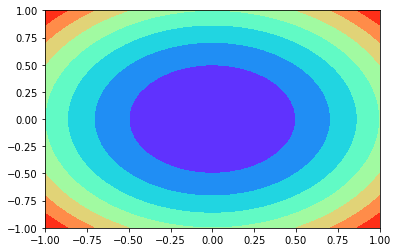

In [41]:
f = Poly(tf.constant([[1, 0, 1],
                      [0, 0, 0],
                      [1, 0, 0],], dtype = K.floatx()))
f([0.1, 0.2])
f.plot([-1,-1], [1, 1])

Its Taylor polynomials at specified grid points (class `TaylorGrid`)

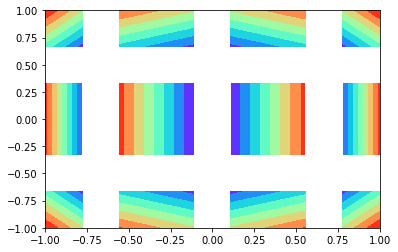

In [42]:
pg = f.get_taylor_grid([[-1, -1/3, 1/3, 1], [-1, 0, 1]], truncs = 2)
pg.plot()

Spline reconstruction (class `PolyMesh`)

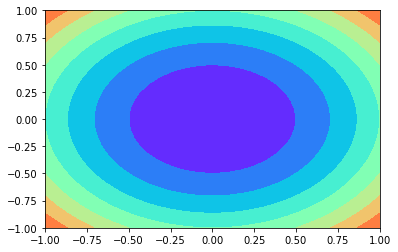

In [43]:
pm = pg.get_spline()
pm.plot()
#pm.contour_plot(levels = np.linspace(-1, 1, 15))

## `PolyMesh` operations

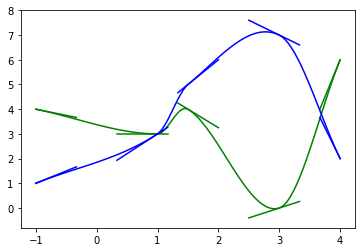

In [44]:
xx = tf.constant([-1, 1, 1.5, 3, 4], K.floatx())

f_tg, g_tg = [
    TaylorGrid.from_Catmull_Rom(
        coef = tf.constant(rnd.randint(10, size = [len(xx)]), dtype= K.floatx()), 
        params = [xx], 
    )
    for i in range(2)
]

f_pm, g_pm = [tg.get_spline() for tg in [f_tg, g_tg]]

#fig, axs = pl.subplots(1, 2, figsize = [10, 4])

f_pm.plot(c = "g")
f_tg.plot(c = "g")
g_pm.plot(c = "b")
g_tg.plot(c = "b")


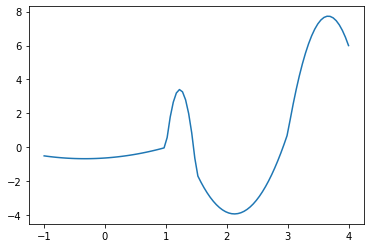

In [45]:
f_pm.der().plot()

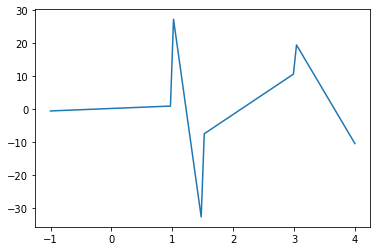

In [46]:
f_pm.der().der().plot()

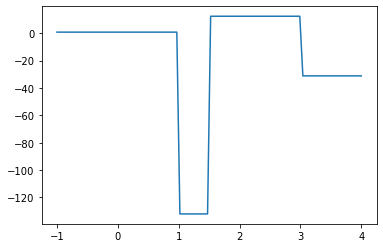

In [47]:
f_pm.der().der().der().plot()

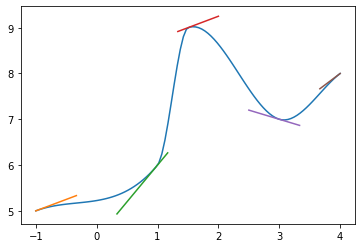

In [48]:
(f_pm + g_pm).plot()
(f_tg + g_tg).plot()

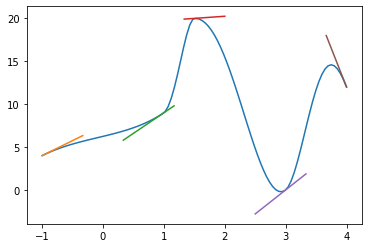

In [49]:
(f_pm * g_pm).plot()
(f_tg * g_tg).plot()

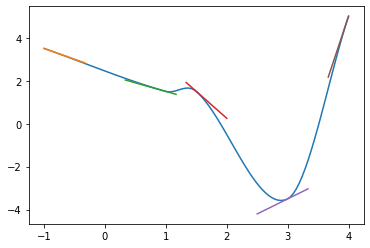

In [50]:
(f_pm - g_pm /2).plot()
(f_tg - g_tg /2).plot()

#### Test derivatives
Derivative of $x^2$ represented as `PolyMesh`.

In [51]:
p = Poly(tf.constant([0, 0, 1], dtype = K.floatx()))
h_tg = p.get_taylor_grid(params = [xx], truncs = 2)

In [52]:
h_pm = h_tg.get_spline()

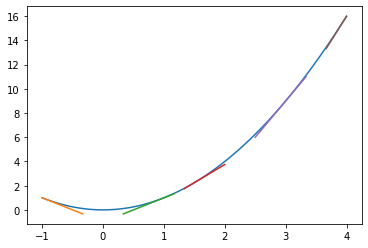

In [53]:
h_pm.plot()
h_tg.plot()

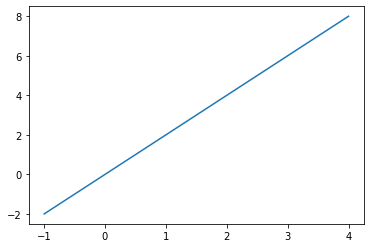

In [54]:
h_pm.der().plot()

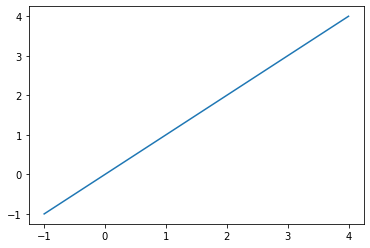

In [55]:
x_pm = h_pm.der() / 2
x_pm.plot()

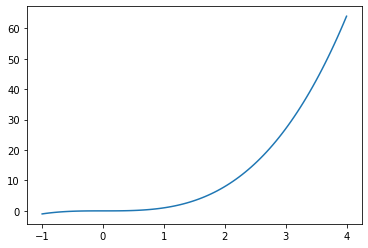

In [56]:
(x_pm * x_pm* x_pm).plot()

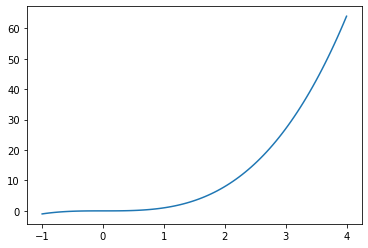

In [57]:
(x_pm ** 3).plot()